In [1]:

import os
import numpy as np
import nibabel as nib
import importlib.util

# Charger le module bruitage manuellement
module_name = "bruitage"
file_path = os.path.abspath('../utils/bruitage.py')
spec = importlib.util.spec_from_file_location(module_name, file_path)
bruitage = importlib.util.module_from_spec(spec)
spec.loader.exec_module(bruitage)


dans le procahin code, les images seront bruitées, il y aura 3 versions bruitées de chaque image, une par bruit ricien (le "Vrai" bruit IRM) présent géneralement dans les régions a faible signal (zones plus sombes), un bruit gaussien (une approximation dans les zones a fort signal) et un bruit mixte pour plus de variabilité dans les données.

Le bruit reste pas trop fort car on veut des images cliniquement exploitables.

In [ ]:

def apply_and_save_noise(image_2d, base_name, output_dir_noisy, output_dir_gt):
    # Ground truth
    gt_path = os.path.join(output_dir_gt, f"{base_name}_clean.npy")
    np.save(gt_path, image_2d)

    # Gaussien faible 
    for std in [30]: 
        img = bruitage.add_gaussian_noise_full(image_2d, stddev=std)
        filename = f"{base_name}_gaussian_std{std}.npy"
        np.save(os.path.join(output_dir_noisy, filename), img)

    # Ricien 2 niveau
    #scale = [20, 50]
    for scale in [40]:
        img = bruitage.add_rician_noise(image_2d, scale=scale)
        filename = f"{base_name}_rician_s{scale}.npy"
        np.save(os.path.join(output_dir_noisy, filename), img)

    # Mix Gaussien + Ricien (gaussien faible et ricien fort)
    img_mix1 = bruitage.add_gaussian_noise_full(image_2d, stddev=25)
    img_mix1 = bruitage.add_rician_noise(img_mix1, scale=30)
    filename = f"{base_name}_gaussian25_rician30.npy"
    np.save(os.path.join(output_dir_noisy, filename), img_mix1)



In [3]:
# essai de bruitage sur un sous-ensembe des images (histoire de faire nos essais, en variant la taille des patchs et notre offset)

import os
import numpy as np
import nibabel as nib

raw_dir = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/raw"
output_dir_noisy = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_subset"
output_dir_gt = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/gt_subset"

os.makedirs(output_dir_noisy, exist_ok=True)
os.makedirs(output_dir_gt, exist_ok=True)

# On sélectionne les 7 premiers patients (fichiers .nii) histoire d'avoir environ une centaine d'images qui aprés bruitage deviennent 300 environ
selected_files = sorted([f for f in os.listdir(raw_dir) if f.endswith(".nii")])[:3]

for fname in selected_files:
    img_path = os.path.join(raw_dir, fname)
    img = nib.load(img_path)
    data = img.get_fdata()  # (slices, H, W)

    for i in range(data.shape[0]):  # généralement 15 slices
        image_2d = data[i].astype(np.uint16)
        base_name = f"{fname[:-4]}_slice{i}"
        apply_and_save_noise(image_2d, base_name, output_dir_noisy, output_dir_gt)

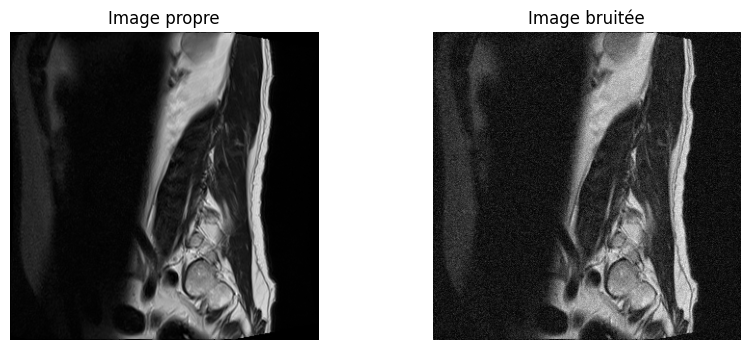

691


In [6]:

import matplotlib.pyplot as plt

noisy_sample = os.path.join(output_dir_noisy, os.listdir(output_dir_noisy)[0])
clean_sample = os.path.join(output_dir_gt, os.listdir(output_dir_gt)[0])

img_noisy = np.load(noisy_sample)
img_clean = np.load(clean_sample)

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.imshow(img_clean, cmap="gray")
plt.title("Image propre")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(img_noisy, cmap="gray")
plt.title("Image bruitée")
plt.axis("off")
plt.show()

print(np.max(img_clean))


In [5]:
output_dir_noisy_strong = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_strong"
output_dir_gt = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/gt_subset"  # même gt car mêmes images
os.makedirs(output_dir_noisy_strong, exist_ok=True)

#fonction pour appliquer un bruit fort aux images (4 ème partie expérimentale)


def apply_and_save_noise_strong(image_2d, base_name, output_dir_noisy, output_dir_gt):
    gt_path = os.path.join(output_dir_gt, f"{base_name}_clean.npy")
    np.save(gt_path, image_2d)
    
    # gaussien fort
    gauss = bruitage.add_gaussian_noise_full(image_2d, stddev=80)
    np.save(os.path.join(output_dir_noisy, f"{base_name}_gaussian80.npy"), gauss)
    
    # ricien fort
    rician = bruitage.add_rician_noise(image_2d, scale=50)
    np.save(os.path.join(output_dir_noisy, f"{base_name}_rician50.npy"), rician)

    # mixte fort
    mix = bruitage.add_gaussian_noise_full(image_2d, stddev=60)
    mix = bruitage.add_rician_noise(mix, scale=40)
    np.save(os.path.join(output_dir_noisy, f"{base_name}_mix_g60_r40.npy"), mix)


raw_dir = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/raw"

selected_files = sorted([f for f in os.listdir(raw_dir) if f.endswith(".nii")])[:3]

for fname in selected_files:
    img_path = os.path.join(raw_dir, fname)
    img = nib.load(img_path)
    data = img.get_fdata()

    for i in range(min(15, data.shape[0])):
        image_2d = data[i].astype(np.uint16)
        base_name = f"{fname[:-4]}_slice{i}"
        apply_and_save_noise_strong(image_2d, base_name, output_dir_noisy_strong, output_dir_gt)



faire un juste mileeux pour comparer , faire la moyenne des métriques pour les 3 niveaux de bruit

In [8]:
output_dir_noisy_medium = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_medium"
output_dir_gt = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/gt_subset"  # même gt car mêmes images
os.makedirs(output_dir_noisy_medium, exist_ok=True)


def apply_and_save_noise_medium(image_2d, base_name, output_dir_noisy, output_dir_gt):
    gt_path = os.path.join(output_dir_gt, f"{base_name}_clean.npy")
    np.save(gt_path, image_2d)
    
    # gaussien : 30 + 30/3
    gauss = bruitage.add_gaussian_noise_full(image_2d, stddev=40)
    np.save(os.path.join(output_dir_noisy, f"{base_name}_gaussian40.npy"), gauss)
    
    # ricien 40 + 40/3
    rician = bruitage.add_rician_noise(image_2d, scale=53)
    np.save(os.path.join(output_dir_noisy, f"{base_name}_rician53.npy"), rician)

    # mixte 
    mix = bruitage.add_gaussian_noise_full(image_2d, stddev=33) # 25 + 25/3
    mix = bruitage.add_rician_noise(mix, scale=40)
    np.save(os.path.join(output_dir_noisy, f"{base_name}_mix_g33_r40.npy"), mix)


raw_dir = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/raw"

selected_files = sorted([f for f in os.listdir(raw_dir) if f.endswith(".nii")])[:3]

for fname in selected_files:
    img_path = os.path.join(raw_dir, fname)
    img = nib.load(img_path)
    data = img.get_fdata()

    for i in range(min(15, data.shape[0])):
        image_2d = data[i].astype(np.uint16)
        base_name = f"{fname[:-4]}_slice{i}"
        apply_and_save_noise_medium(image_2d, base_name, output_dir_noisy_medium, output_dir_gt)


La blur metric est basée sur sur la variance du Laplacien : c'est une mesure de la netteté d'une image. Le Laplacien détecte les bords et plus les bords sont nets plus la variance augmente, et donc plus l'image est floue, moins on a de bords et plus la variance baisse.

L = Laplacien(I)
Blur(I) = Var(L)

In [ ]:
import cv2

def blur_metric(img):
    if img.dtype != np.uint8:
        img = ((img / 4095) * 255).astype(np.uint8)
    return cv2.Laplacian(img, cv2.CV_32F).var()

In [9]:
# bruitage de de données de différents patients 

output_dir_3 = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_3"
gt_dir_3 = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/gt_3"
os.makedirs(output_dir_3, exist_ok=True)
os.makedirs(gt_dir_3, exist_ok=True)

raw_dir = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/raw"
selected_files = sorted([f for f in os.listdir(raw_dir) if f.endswith(".nii")])[4:7]


for fname in selected_files:
    img_path = os.path.join(raw_dir, fname)
    img = nib.load(img_path)
    data = img.get_fdata()
    
    # pour cahque patient je prends 1 seul slice, ca sera le premier slice
    image_2d = data[0].astype(np.uint16)
    base_name = f"{fname[:-4]}_slice{0}"
    apply_and_save_noise_medium(image_2d, base_name, output_dir_3, gt_dir_3)
    


(np.float64(-0.5), np.float64(383.5), np.float64(383.5), np.float64(-0.5))

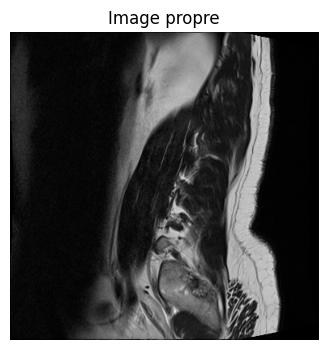

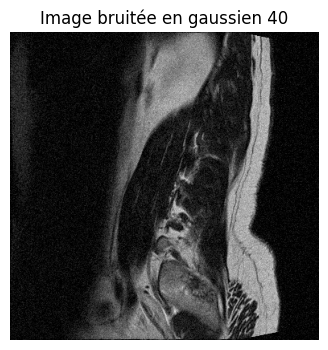

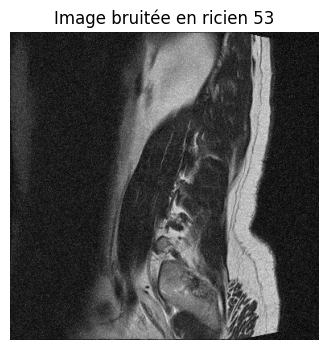

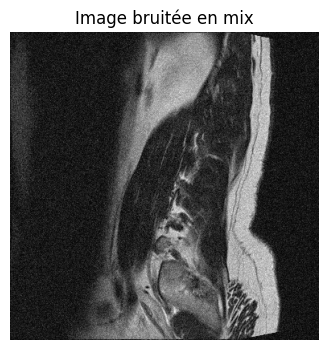

In [3]:
import numpy as np
import matplotlib.pyplot as plt

gt_path = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/gt_subset/1_slice0_clean.npy"
noisy_gaussian = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_medium/1_slice0_gaussian40.npy"
noisy_mix = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_medium/1_slice0_mix_g33_r40.npy"
noisy_rician = "C:/Users/Asus/Desktop/M1-IMA/PIMA/data/noisy_medium/1_slice0_rician53.npy"

image_originale = np.load(gt_path)
image_g = np.load(noisy_gaussian)
image_mix = np.load(noisy_mix)
image_r = np.load(noisy_rician)

plt.figure(figsize=(10, 4))
plt.imshow(image_originale, cmap="gray")
plt.title("Image propre")
plt.axis("off") 

plt.figure(figsize=(10, 4))
plt.imshow(image_g, cmap="gray")
plt.title("Image bruitée en gaussien 40")
plt.axis("off")

plt.figure(figsize=(10, 4))
plt.imshow(image_r, cmap="gray")
plt.title("Image bruitée en ricien 53")
plt.axis("off")

plt.figure(figsize=(10, 4))
plt.imshow(image_mix, cmap="gray")
plt.title("Image bruitée en mix")
plt.axis("off")
